In [2]:
import os
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.image import resample_img
import pandas as pd

In [3]:
def avgPdata(data_path: str, par_num: str, mask_size: tuple) -> nib.Nifti1Image:
    """
    data_path::str - path to where the searchlight results are stored
    par_num::str - the particpant for which we are going to load data
    mask_size::tuple - size of the output, should be the same as the searchlight volume
                       and the whole brian mask
    """
    # find the participant number
    fstr = lambda x: int(x.split("/")[-1].split("_")[-1].split(".nii.gz")[0].split("s")[-1])
    files = [x for x in data_path if par_num == fstr(x)]
    n = len(files)
    # returned averaged data
    data = np.zeros(mask_size)
    # compute the average
    for idx, f in enumerate(files):
        data_obj = nib.load(f)
        if idx == n - 1:
            affine = data_obj.affine
        # doing it recursively
        data += (1/(idx+1)) * (np.array(data_obj.dataobj) - data)
    return nib.Nifti1Image(data, affine=affine)

In [6]:
def toppvol(data: np.array, p: int, affine: np.array, binary: bool = False, nifti: bool = True):
    """
    data::np.array - input data from a nibabel image, this is the searchlight result volume
    p::int - the percentile to calculate
    affine::np.array - affine matrix to create the output nibabel image
    binary::bool - boolean to determine if output is binarized or not
    nifti::bool - boolean to determine if the output is a nibabel image or a numpy array
    """
    dcopy = data.copy()
    pcent = np.percentile(dcopy, p)
    
    if binary:
        dcopy[dcopy < pcent] = 0
        dcopy[dcopy >= pcent] = 1
    else:
        dcopy[dcopy < pcent] = 0
    
    if nifti:
        return nib.Nifti1Image(dcopy, affine=affine)
    return dcopy

def simple_group_stats(data_objs: list, p: int, binary: bool, nifti: bool, shape: tuple) -> nib.Nifti1Image:
    """
    for each subject, make a volume where a voxel is 1 if it was in the top 1% for
    that subject/layer and 0 if it wasn’t (edited) 
    this should give you 16 volumes per layer (because 16 subjects)
    then sum across subjects so you get a volume per layer
    and look how it changes
    """
    # to save layer specific images
    result = np.zeros(shape)
    
    #sn = lambda x: x.split("_")[-1].split(".")[0]
    
    for do in data_objs:
        result += toppvol(do.dataobj, p=p, affine=do.affine, binary=binary, nifti=nifti)
    
    return nib.Nifti1Image(result, affine=data_objs[0].affine)

In [7]:
MASK_SHAPE = (61, 73, 61)
TOTAL_PARS = 17

INFO = {
    "CV": {
            "LAYERS": (1, 4, 7, 9, 11),
            "DIR": "/media/yoel/second_ssd/neu502b/results/rsak10/",
            "fl": lambda x: int(x.split("relu")[-1].split("cormat")[0]),
            "fp": lambda x: int(x.split("/")[-1].split("relu")[0][1])
          },
    "FC": {
            "LAYERS": (2, 5, 6),
            "DIR": "/media/yoel/second_ssd/neu502b/results/rsak10fc/",
            "fl": lambda x: int(x.split("fc")[-1].split("cormat")[0]),
            "fp": lambda x: int(x.split("/")[-1].split("fc")[0][1])
          }
}

for net_layer_type in ["CV", "FC"]:
    RSA_DIR = INFO[net_layer_type]["DIR"]
    layers = {l:[] for l in INFO[net_layer_type]["LAYERS"]}
    
    for x in os.listdir(RSA_DIR):
        layers[INFO[net_layer_type]["fl"](x)].append(os.path.join(RSA_DIR, x))
        
    group = {}
    
    for l in INFO[net_layer_type]["LAYERS"]:
        indiv_pars = [avgPdata(layers[l], i+1, MASK_SHAPE) for i in range(TOTAL_PARS)]
        group[l] = [simple_group_stats(indiv_pars,99, True, False, MASK_SHAPE)]
        group[l].append(indiv_pars)
        
    INFO[net_layer_type]["group"] = group

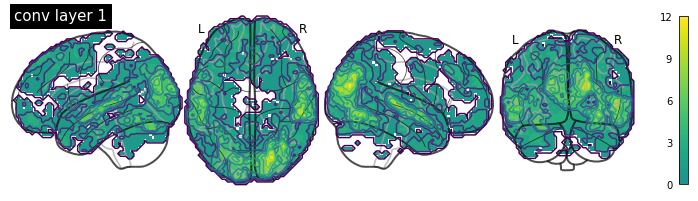

In [8]:
l=1
display = plotting.plot_glass_brain(INFO["CV"]["group"][l][0], display_mode='lzry', 
                                    colorbar=True, cmap="viridis")
display.add_contours(INFO["CV"]["group"][l][0])
display.title("conv layer {}".format(l))
plt.savefig("conv layer {}.png".format(l), dpi=100)

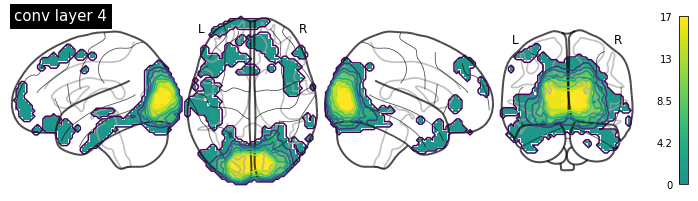

In [9]:
l=4
display = plotting.plot_glass_brain(INFO["CV"]["group"][l][0], display_mode='lzry', 
                                    colorbar=True, cmap="viridis")
display.add_contours(INFO["CV"]["group"][l][0])
display.title("conv layer {}".format(l))
plt.savefig("conv layer {}.png".format(l), dpi=100)

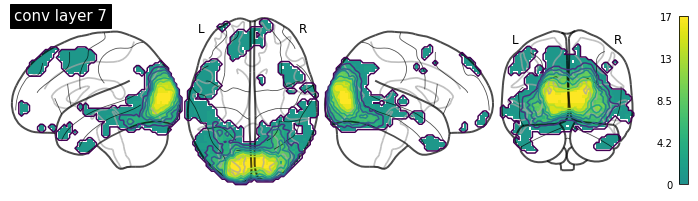

In [10]:
l=7
display = plotting.plot_glass_brain(INFO["CV"]["group"][l][0], display_mode='lzry', 
                                    colorbar=True, cmap="viridis")
display.add_contours(INFO["CV"]["group"][l][0])
display.title("conv layer {}".format(l))
plt.savefig("conv layer {}.png".format(l), dpi=100)

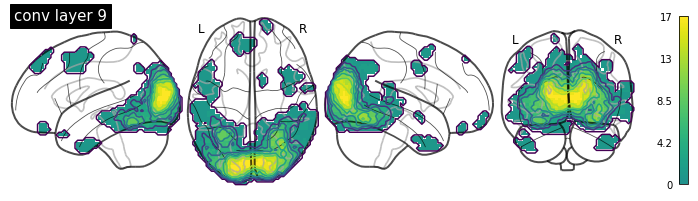

In [11]:
l=9
display = plotting.plot_glass_brain(INFO["CV"]["group"][l][0], display_mode='lzry', 
                                    colorbar=True, cmap="viridis")
display.add_contours(INFO["CV"]["group"][l][0])
display.title("conv layer {}".format(l))
plt.savefig("conv layer {}.png".format(l), dpi=100)

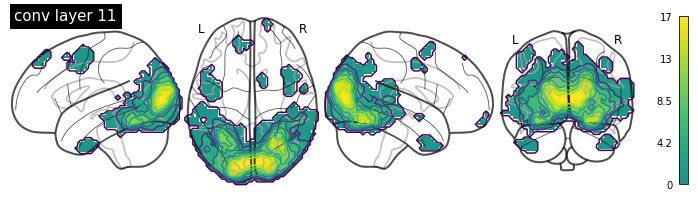

In [12]:
l=11
display = plotting.plot_glass_brain(INFO["CV"]["group"][l][0], display_mode='lzry', 
                                    colorbar=True, cmap="viridis")
display.add_contours(INFO["CV"]["group"][l][0])
display.title("conv layer {}".format(l))
plt.savefig("conv layer {}.png".format(l), dpi=100)

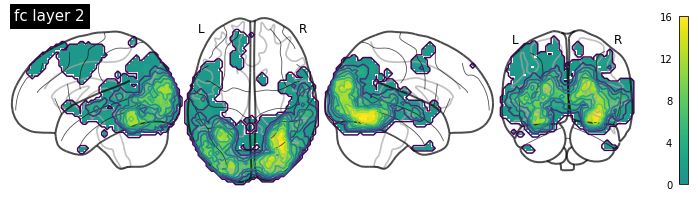

In [13]:
l=2
display = plotting.plot_glass_brain(INFO["FC"]["group"][l][0], display_mode='lzry', 
                                    colorbar=True, cmap="viridis")
display.add_contours(INFO["FC"]["group"][l][0])
display.title("fc layer {}".format(l))
plt.savefig("fc layer {}.png".format(l), dpi=100)

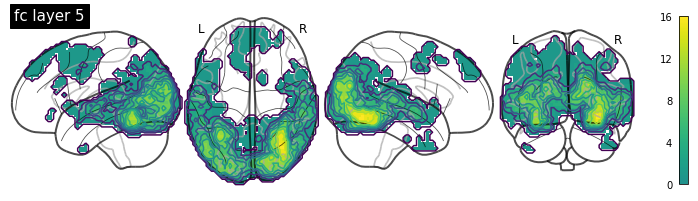

In [14]:
l=5
display = plotting.plot_glass_brain(INFO["FC"]["group"][l][0], display_mode='lzry', 
                                    colorbar=True, cmap="viridis")
display.add_contours(INFO["FC"]["group"][l][0])
display.title("fc layer {}".format(l))
plt.savefig("fc layer {}.png".format(l), dpi=100)

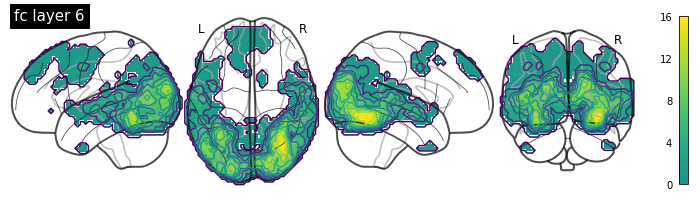

In [15]:
l=6
display = plotting.plot_glass_brain(INFO["FC"]["group"][l][0], display_mode='lzry', 
                                    colorbar=True, cmap="viridis")
display.add_contours(INFO["FC"]["group"][l][0], threshold=16)
display.title("fc layer {}".format(l))
plt.savefig("fc layer {}.png".format(l), dpi=100)

In [16]:
MASK_DIR = "/media/yoel/second_ssd/neu502b/reqs"
WHOLE_MASK = "/media/yoel/second_ssd/neu502b/reqs/3mm_mask.nii.gz"
left_V1 = "/media/yoel/second_ssd/neu502b/reqs/left_V1_mask.nii.gz"
right_V1 = "/media/yoel/second_ssd/neu502b/reqs/right_V1_mask.nii.gz"
left_FFA = "/media/yoel/second_ssd/neu502b/reqs/left_FFA_mask.nii.gz"
right_FFA = "/media/yoel/second_ssd/neu502b/reqs/right_FFA_mask.nii.gz"

In [17]:
wholebrainmask = nib.load(WHOLE_MASK)
maskimg = nib.load(left_V1)

def squeeze_mask(img: nib.Nifti1Image) -> nib.Nifti1Image:
    """
    img::nib.Nift1Image - nibabel image
         this will return the image with the last dimension squeezed out
    """
    data = np.array(img.dataobj)
    data = data.squeeze()
    return nib.Nifti1Image(data, affine=img.affine)

# testing
maskimg = squeeze_mask(maskimg)

In [18]:
maskimg = nib.load(left_V1)
plotting.plot_glass_brain(squeeze_mask(maskimg), output_file="left_V1.png")
maskimg = nib.load(right_V1)
plotting.plot_glass_brain(squeeze_mask(maskimg), output_file="right_V1.png")
maskimg = nib.load(right_FFA)
plotting.plot_glass_brain(squeeze_mask(maskimg), output_file = "right_FFA.png")
maskimg = nib.load(left_FFA)
plotting.plot_glass_brain(squeeze_mask(maskimg), output_file="left_FFA.png")

In [19]:
out = resample_img(maskimg, target_affine=wholebrainmask.affine, target_shape=MASK_SHAPE, interpolation='nearest')
print(out.shape)

(61, 73, 61, 1)


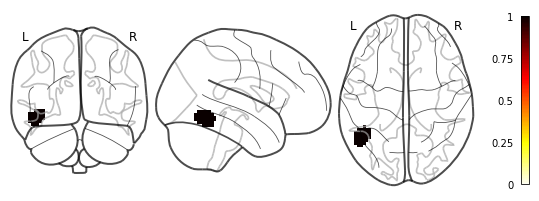

In [26]:
plotting.plot_glass_brain(out, colorbar=True)

In [28]:
def apply_roi_mask(data_img: nib.Nifti1Image, whole_brain_mask_path: str, roi_mask_path: str) -> tuple:
    """
    data_img:: input nibabel object, this is the group level volume created
               from binarizaing and summing the individual level volume search light results
    whole_brain_mask_path::str - path to the 3mm brain mask, used for resampling
    roi_mask_path::str - path to the ROI mask, to be used to mask the data
    """
    whole_bm = nib.load(whole_brain_mask_path)
    mask_shape = np.array(whole_bm.dataobj).shape
    roi_bm = nib.load(roi_mask_path)
    resampled_roi_bm = resample_img(roi_bm, target_affine=whole_bm.affine, 
                                    target_shape=mask_shape, interpolation='nearest')
    if len(resampled_roi_bm.shape) > 3 and resampled_roi_bm.shape[-1] == 1:
        resampled_roi_bm = squeeze_mask(resampled_roi_bm)
    masked_img_data = np.array(data_img.dataobj)[np.array(resampled_roi_bm.dataobj.astype(bool))]
    return resampled_roi_bm, masked_img_data

In [29]:
def compute_overlaps(INFO: dict, WHOLE_MASK: str, roi: str) -> dict:
    """
    INFO::dict - input dictionary with some information and compiled group
                 level results needed for these further analysis
    WHOLE_MASK::str - path to the 3mm whole brain mask, will be applied as in 
                      the function apply_roi_mask()
    roi::str - path to the roi mask, as will be applied in the function apply_roi_mask()
    """
    overlap_obj = {"CV":{}, "FC":{}}
    for ctype in ["CV", "FC"]:
        layers = INFO[ctype]["LAYERS"]
        for l in layers:
            group_data = INFO[ctype]["group"][l][0]
            _, overlap = apply_roi_mask(group_data, WHOLE_MASK, roi)
            overlap_obj[ctype][l] = overlap
    return overlap_obj

In [30]:
overlap_right_FFA = compute_overlaps(INFO, WHOLE_MASK, right_FFA)
overlap_left_FFA = compute_overlaps(INFO, WHOLE_MASK, left_FFA)
overlap_right_V1 = compute_overlaps(INFO, WHOLE_MASK, right_V1)
overlap_left_V1 = compute_overlaps(INFO, WHOLE_MASK, left_V1)

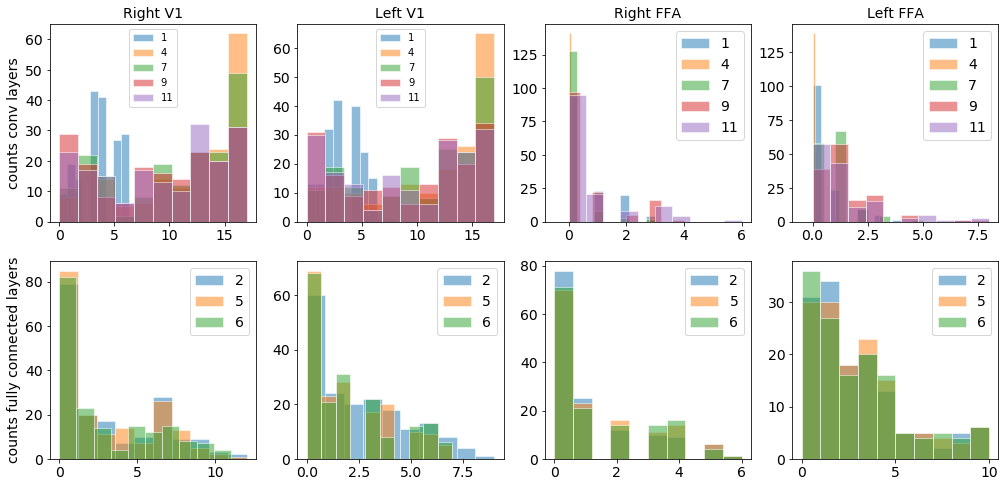

In [31]:
FS=14
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(17, 8))
for l in INFO["CV"]["LAYERS"]:
    ax[0, 0].hist(overlap_right_V1["CV"][l], edgecolor="white", alpha=0.5)
    ax[0, 1].hist(overlap_left_V1["CV"][l], edgecolor="white", alpha=0.5)
ax[0, 0].legend(INFO["CV"]["LAYERS"])
ax[0, 1].legend(INFO["CV"]["LAYERS"]) 

for l in INFO["FC"]["LAYERS"]:
    ax[1, 0].hist(overlap_right_V1["FC"][l], edgecolor="white", alpha=0.5)
    ax[1, 1].hist(overlap_left_V1["FC"][l], edgecolor="white", alpha=0.5)

ax[1, 0].legend(INFO["FC"]["LAYERS"], fontsize=FS)
ax[1, 1].legend(INFO["FC"]["LAYERS"], fontsize=FS)     
    
ax[0, 0].set_title("Right V1", fontsize=FS)
ax[0, 1].set_title("Left V1", fontsize=FS)

for l in INFO["CV"]["LAYERS"]:
    ax[0, 2].hist(overlap_right_FFA["CV"][l], edgecolor="white", alpha=0.5)
    ax[0, 3].hist(overlap_left_FFA["CV"][l], edgecolor="white", alpha=0.5)
ax[0, 2].legend(INFO["CV"]["LAYERS"], fontsize=FS)
ax[0, 3].legend(INFO["CV"]["LAYERS"], fontsize=FS) 

for l in INFO["FC"]["LAYERS"]:
    ax[1, 2].hist(overlap_right_FFA["FC"][l], edgecolor="white", alpha=0.5)
    ax[1, 3].hist(overlap_left_FFA["FC"][l], edgecolor="white", alpha=0.5)

ax[1, 2].legend(INFO["FC"]["LAYERS"], fontsize=FS)
ax[1, 3].legend(INFO["FC"]["LAYERS"], fontsize=FS)     
    
ax[0, 2].set_title("Right FFA", fontsize=FS)
ax[0, 3].set_title("Left FFA", fontsize=FS)

ax[0, 0].set_ylabel("counts conv layers", fontsize=FS)
ax[1, 0].set_ylabel("counts fully connected layers", fontsize=FS)

for i, a in enumerate(ax.flatten()):
    a.tick_params(axis="both", labelsize=FS)
    
plt.savefig("overlaphists_rois.png", dpi=100, bbox_inches="tight")

In [32]:
NN_fc5 = np.load("/media/yoel/second_ssd/neu502b/results/nncormats/p2fc5cormat.npy")
NN_fc1 = np.load("/media/yoel/second_ssd/neu502b/results/nncormats/p2relu1cormat.npy")

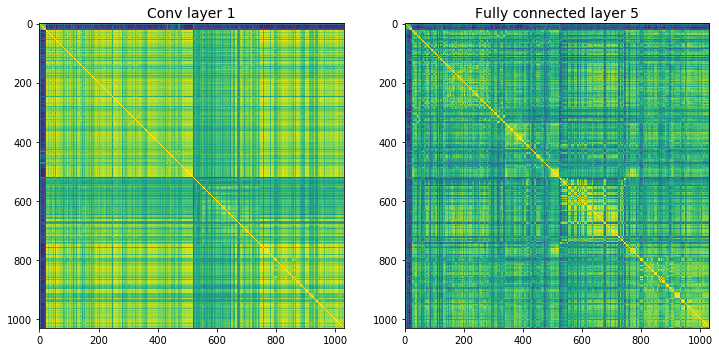

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
ax[0].imshow(NN_fc1)
ax[1].imshow(NN_fc5)
ax[0].set_title("Conv layer 1", fontsize=FS)
ax[1].set_title("Fully connected layer 5", fontsize=FS)
plt.savefig("NNcorExamples.png", dpi=200, bbox_inches="tight")